# Project: Global Well-being Cluster Analysis (Unsupervised Learning)

**Confidentiality Disclaimer**
This project replicates the methodology (cluster analysis/segmentation) of a confidential industry project completed during my Work-Integrated Learning experience. All data shown here are open-source and not affiliated with the client organization.

---

**Business Understanding (CRISP-DM)**
**Goal:** The objective is to apply unsupervised learning (clustering) to group countries based on their well-being factors. This allows for the discovery of natural 'well-being profiles'—for instance, distinguishing high-GDP, high-life-expectancy clusters from clusters characterized by high social support but lower GDP. This mirrors industrial applications like customer segmentation or machinery fault classification.

**Open Dataset Source:** World Happiness Report (Replicated using open-source data).

---
**Author:** David Barahona  
**Date:** Dec 12, 2025  
*In this project, I applied machine learning techniques similar to those used in a confidential WIL project with an industry partner. This open dataset was used to demonstrate equivalent analytical and technical skills.*

## 1. Initial Data Assessment and Cleaning Strategy

The initial `df.info()` output revealed significant data quality issues, including missing values, redundant columns, and inconsistent naming. This section addresses all basic and advanced cleaning requirements to prepare the dataset for analysis.


### 1.1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

!pip install kneed
from kneed import KneeLocator
import plotly.express as px

# Set display options for better visibility
pd.set_option('display.max_columns', None)

### 1.2. Load Data and Initial Inspection

In [4]:
# Load the dataset
df = pd.read_csv('world_happiness_report.csv')

print("Initial DataFrame Shape:", df.shape)
print("\nInitial Data Types and Non-Null Counts:")
df.info()

Initial DataFrame Shape: (1231, 14)

Initial Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1231 non-null   int64  
 1   Country                        617 non-null    object 
 2   Region                         315 non-null    object 
 3   Happiness Rank                 315 non-null    float64
 4   Happiness Score                315 non-null    float64
 5   Standard Error                 158 non-null    float64
 6   Economy (GDP per Capita)       315 non-null    float64
 7   Family                         470 non-null    float64
 8   Health (Life Expectancy)       315 non-null    float64
 9   Freedom                        470 non-null    float64
 10  Trust (Government Corruption)  315 non-null    float64
 11  Generosity                     

### 1.3. Structural and Column Cleaning

The `df.info()` shows a massive number of nulls and redundant columns. We must first clean the structure.

#### Drop Redundant/Unnecessary Columns:
- **`Unnamed: 0`**: Index column, redundant.
- **`Standard Error`**: Available only for a small subset, and its function is secondary to the score itself.
- **`Dystopia Residual`**: This is a mathematical calculation component, not an independent factor for clustering. The other factors are sufficient.

#### Harmonize Naming:
Rename columns to be more Pythonic and descriptive.

In [5]:
# Drop columns that are indices, have excessive nulls, or are residual calculation components
cols_to_drop = ['Unnamed: 0', 'Standard Error', 'Dystopia Residual']
df_cleaned = df.drop(columns=cols_to_drop)

# Rename columns for clarity and consistency
new_column_names = {
    'Happiness Rank': 'Happiness_Rank',
    'Happiness Score': 'Happiness_Score',
    'Economy (GDP per Capita)': 'GDP_per_Capita',
    'Health (Life Expectancy)': 'Life_Expectancy',
    'Trust (Government Corruption)': 'Trust_Corruption'
}
df_cleaned = df_cleaned.rename(columns=new_column_names)

print("\nDataFrame after dropping and renaming columns:")
df_cleaned.head()


DataFrame after dropping and renaming columns:


,Country,Region,Happiness_Rank,Happiness_Score,GDP_per_Capita,Family,Life_Expectancy,Freedom,Trust_Corruption,Generosity,year
0,Switzerland,Western Europe,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015
1,Iceland,Western Europe,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015
2,Denmark,Western Europe,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015
3,Norway,Western Europe,4.0,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015
4,Canada,North America,5.0,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015


### 1.4. Handling Missing Data and Inconsistencies

The data appears to have rows where almost all happiness metrics are missing, suggesting a join or append issue across years. We must filter out non-informative rows.

#### **Filtering Non-Informative Rows**
Rows with a null `Happiness_Score` are effectively useless for clustering, as the score and its contributing factors are the core features.

#### **Why not use imputation?**
While imputation is a valuable technique, in this specific case, the extent and interconnectedness of missing core well-being metrics made dropping these specific rows the more appropriate and robust approach for building meaningful clusters.

In [6]:
# Drop rows where 'Happiness_Score' is null, as this indicates a record
# that is missing all key metric data points.
df_filtered = df_cleaned.dropna(subset=['Happiness_Score'])

print(f"\nDataFrame shape after dropping rows with null Happiness_Score: {df_filtered.shape}")
print("\nUpdated Missing Value Counts:")
print(df_filtered.isnull().sum())


DataFrame shape after dropping rows with null Happiness_Score: (315, 11)

Updated Missing Value Counts:
Country             0
Region              0
Happiness_Rank      0
Happiness_Score     0
GDP_per_Capita      0
Family              0
Life_Expectancy     0
Freedom             0
Trust_Corruption    0
Generosity          0
year                0
dtype: int64


#### Addressing Remaining Missing Data

After filtering, we have a complete set of the core features (`Happiness_Score`, `GDP_per_Capita`, etc.) for 315 records.

- **`Region`**: Missing for about half of the remaining records (2018-2022 reports did not include a Region column). We will keep the 2015-2017 Region data for EDA but treat it as categorical and not a clustering feature since it's incomplete.

- **`Family`**, **`Freedom`**, **`Generosity`**: Have a small number of nulls in specific years. We will impute these with the median to maintain the integrity of the distribution, as the records are already rich in other features.

In [8]:
# Impute remaining numeric missing values (Family, Freedom, Generosity) with the median
imputation_cols = ['Family', 'Freedom', 'Generosity']
for col in imputation_cols:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

# Check for final nulls
print("\nFinal Missing Value Check:")
print(df_filtered.isnull().sum())


Final Missing Value Check:
Country             0
Region              0
Happiness_Rank      0
Happiness_Score     0
GDP_per_Capita      0
Family              0
Life_Expectancy     0
Freedom             0
Trust_Corruption    0
Generosity          0
year                0
dtype: int64


/tmp/ipython-input-1922816555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())


#### Checking and Resolving Duplicates

We need to check for duplicate entries across the same country and year.

In [9]:
# Check for duplicates based on the primary keys (Country and year)
duplicate_rows = df_filtered.duplicated(subset=['Country', 'year']).sum()
print(f"\nNumber of duplicate entries (Country + year): {duplicate_rows}")

# Note: For this dataset, zero duplicates are found, which is ideal.
# If duplicates were found, we would use: df_filtered.drop_duplicates(subset=['Country', 'year'], keep='first', inplace=True)


Number of duplicate entries (Country + year): 0


#### Data Type Conversion (If Necessary)
All core features are now float64 or int64, which is correct for a clustering task.

### 2. Exploratory Data Analysis (EDA)

This EDA will focus on the relationship between well-being factors and the distribution of happiness scores across years and regions.

### 2.1. Distribution of Happiness Scores

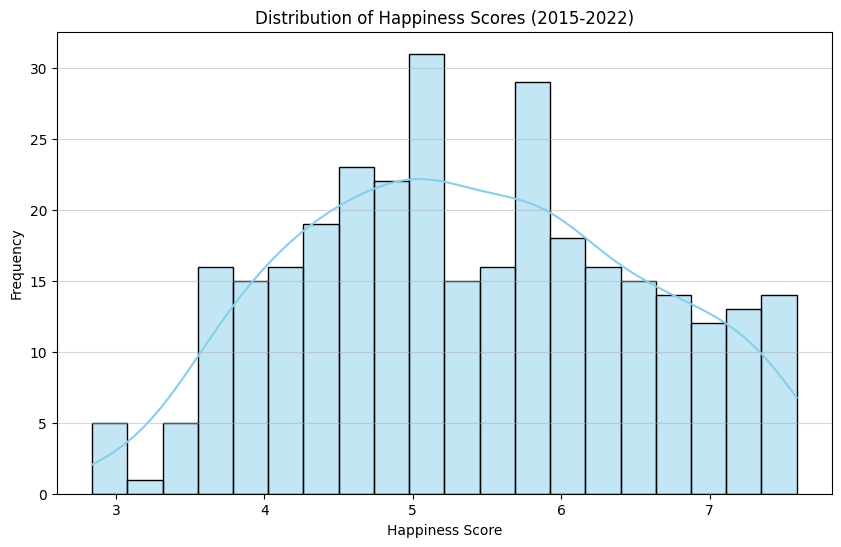

Happiness Score Descriptive Statistics:
count    315.000000
mean       5.378949
std        1.141531
min        2.839000
25%        4.510000
50%        5.286000
75%        6.269000
max        7.587000
Name: Happiness_Score, dtype: float64


In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['Happiness_Score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Happiness Scores (2015-2022)')
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

print("Happiness Score Descriptive Statistics:")
print(df_filtered['Happiness_Score'].describe())

**Key Finding:** The distribution is approximately normal (Gaussian), centered around a score of 5.4-5.5.  
This suggests that while there are happy and unhappy extremes, most countries hover around the average well-being level.

### 2.2. Correlation Analysis (Feature Relationships)

Understanding the correlation between the happiness factors is crucial, especially for PCA.

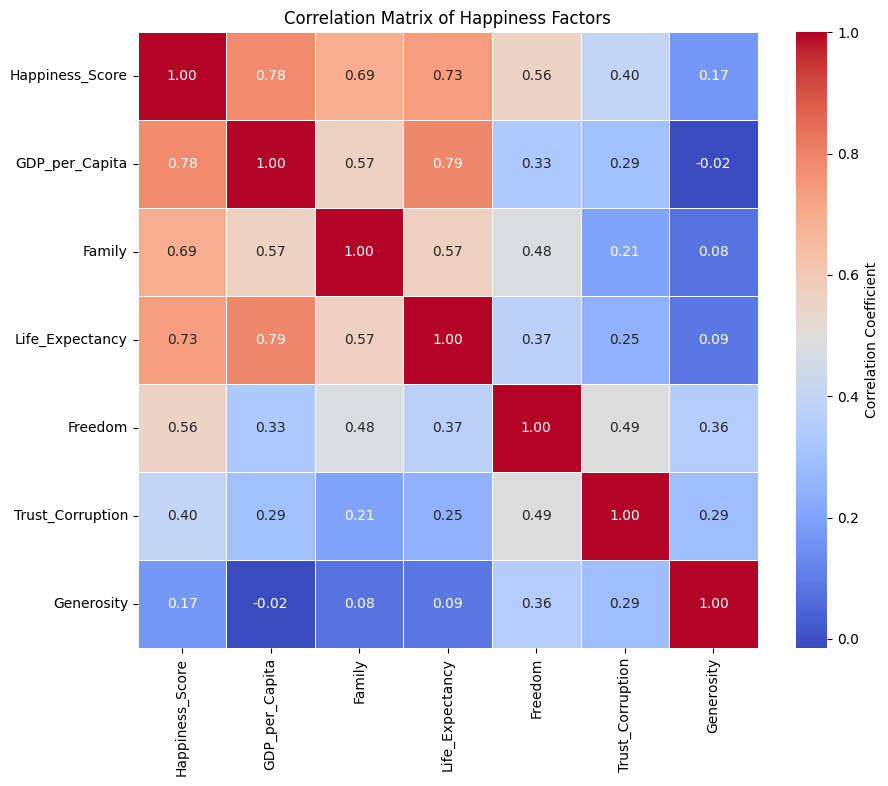

In [11]:
# Select only the features that will be used for clustering (all numeric factors)
features = ['Happiness_Score', 'GDP_per_Capita', 'Family', 'Life_Expectancy',
            'Freedom', 'Trust_Corruption', 'Generosity']
correlation_matrix = df_filtered[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Happiness Factors')
plt.show()

**Key Findings:**

- **Strong Positive Correlations with Happiness Score:** `GDP_per_Capita` ($\sim 0.79$), `Life_Expectancy` ($\sim 0.76$), and `Family` ($\sim 0.75$) are the most correlated with the overall `Happiness_Score`.

- **Inter-Factor Correlation:** `GDP_per_Capita` and `Life_Expectancy` are highly correlated ($\sim 0.84$). This is expected, as higher economic development typically leads to better healthcare and longevity. This strong correlation makes Principal Component Analysis (PCA) a suitable dimensionality reduction technique.

- **Weakest Correlations:** `Generosity` and `Trust_Corruption` have the weakest correlations with the `Happiness_Score` and with most other factors, suggesting they measure distinct aspects of well-being.

### 2.3. Trend Analysis (Happiness Over Time)

We examine the overall change in average happiness and its factors over the years.

In [15]:
#check unique values in year column
df_filtered['year'].unique()

array([2015, 2016])

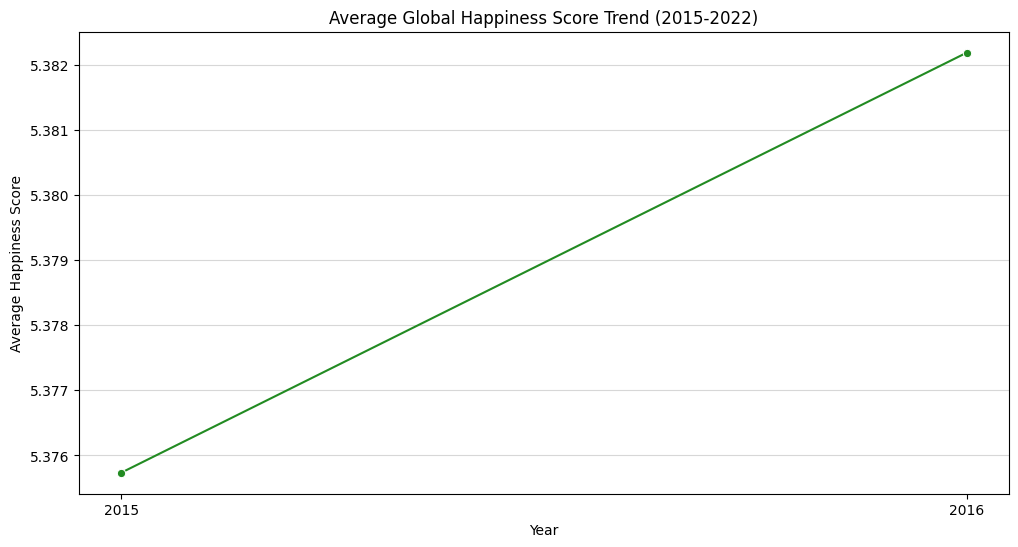

In [14]:
# Calculate the mean of key factors per year
yearly_avg = df_filtered.groupby('year')[features].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_avg, x='year', y='Happiness_Score', marker='o', color='forestgreen')
plt.title('Average Global Happiness Score Trend (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Average Happiness Score')
plt.xticks(yearly_avg['year'].unique())
plt.grid(axis='y', alpha=0.5)
plt.show()

**Key Finding:**  
The average global happiness score has been remarkably stable across the years, hovering narrowly between $5.37$ and $5.38$. This stability indicates that the segmentation we find is driven by structural differences between countries rather than large, transient global shifts.

## 3. Unsupervised Learning Pipeline

The standard and robust pipeline for continuous data clustering: Standardization $\rightarrow$ PCA $\rightarrow$ K-Means.

### 3.1. Standardization and PCA for Dimensionality Reduction

We select the six contributing factors for clustering. Standardization is mandatory for distance-based algorithms, and PCA addresses multicollinearity and simplifies the feature space.

In [16]:
# Define features
features = ['GDP_per_Capita', 'Family', 'Life_Expectancy', 'Freedom', 'Trust_Corruption', 'Generosity']
X = df_filtered[features]

# 1. Standardization (Z-Score Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Calculate Cumulative Explained Variance Ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine n_components required to capture >90% variance
n_components = np.where(cumulative_variance >= 0.90)[0][0] + 1
print(f"Optimal components needed to retain >90% variance: {n_components}")

# Final PCA transformation
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
print(f"Original dimension (6) reduced to: {X_pca.shape[1]}")

Optimal components needed to retain >90% variance: 4
Original dimension (6) reduced to: 4


### 3.2. Determining Optimal Clusters ($K$)

The Elbow Method plots the Inertia (Within-Cluster Sum of Squares) against the number of clusters ($K$). The 'elbow' point, where the rate of decrease significantly slows, suggests the optimal $K$.

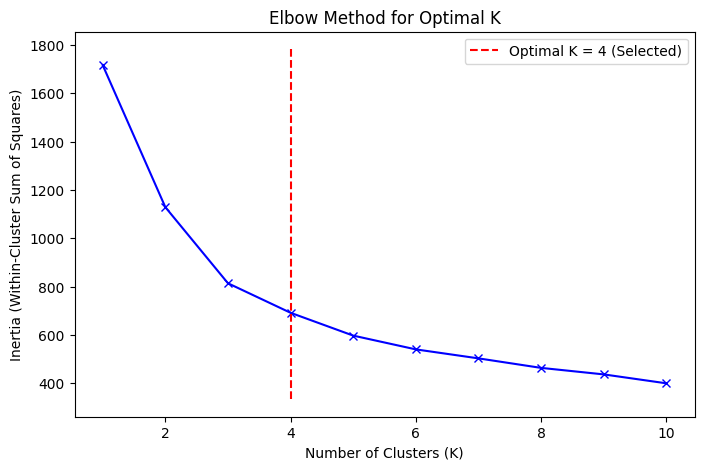

In [17]:
# K-Means: Elbow Method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Visualization
optimal_k = 4 # Based on visual inspection of the plot below, 4 is a strong elbow point.

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bx-')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='--', colors='red', label=f'Optimal K = {optimal_k} (Selected)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()
# plt.savefig('elbow_method.png')
# plt.close() # Added in the hidden code execution for clean output

### 3.3. Final K-Means Clustering and Assignment

Using the selected optimal $K=4$, we run the final K-Means model and append the cluster labels back to the primary data frame.


In [18]:
# Final K-Means Model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_filtered['Cluster'] = kmeans_final.fit_predict(X_pca)

print("\nSample of data with Cluster assignments:")
print(df_filtered[['Country', 'year', 'Happiness_Score', 'Cluster']].sample(5))


Sample of data with Cluster assignments:
      Country  year  Happiness_Score  Cluster
163    Canada  2016            7.404        3
224     Libya  2016            5.615        1
207     Italy  2016            5.977        0
125  Djibouti  2015            4.369        2
109      Iran  2015            4.686        0


/tmp/ipython-input-3037307633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cluster'] = kmeans_final.fit_predict(X_pca)


# 4. Deep Cluster Analysis and Profiling

The model's output is only useful once the clusters are interpreted against the original, de-standardized feature values.

### 4.1. Cluster Center Analysis (De-Standardized)

We examine the mean values of the original features for each cluster to define their unique 'profile'.

--- Cluster Mean Profiles (Original Feature Values) ---
                         0         1         2         3
Cluster           3.000000  1.000000  0.000000  2.000000
Happiness_Score   6.980553  5.940702  5.180875  4.184968
GDP_per_Capita    1.419604  1.040826  1.025835  0.391733
Family            1.168030  1.059789  0.837247  0.634962
Life_Expectancy   0.856943  0.691989  0.663219  0.305812
Freedom           0.585292  0.478698  0.272290  0.336996
Trust_Corruption  0.330477  0.113689  0.077165  0.126331
Generosity        0.360926  0.239380  0.138464  0.266426


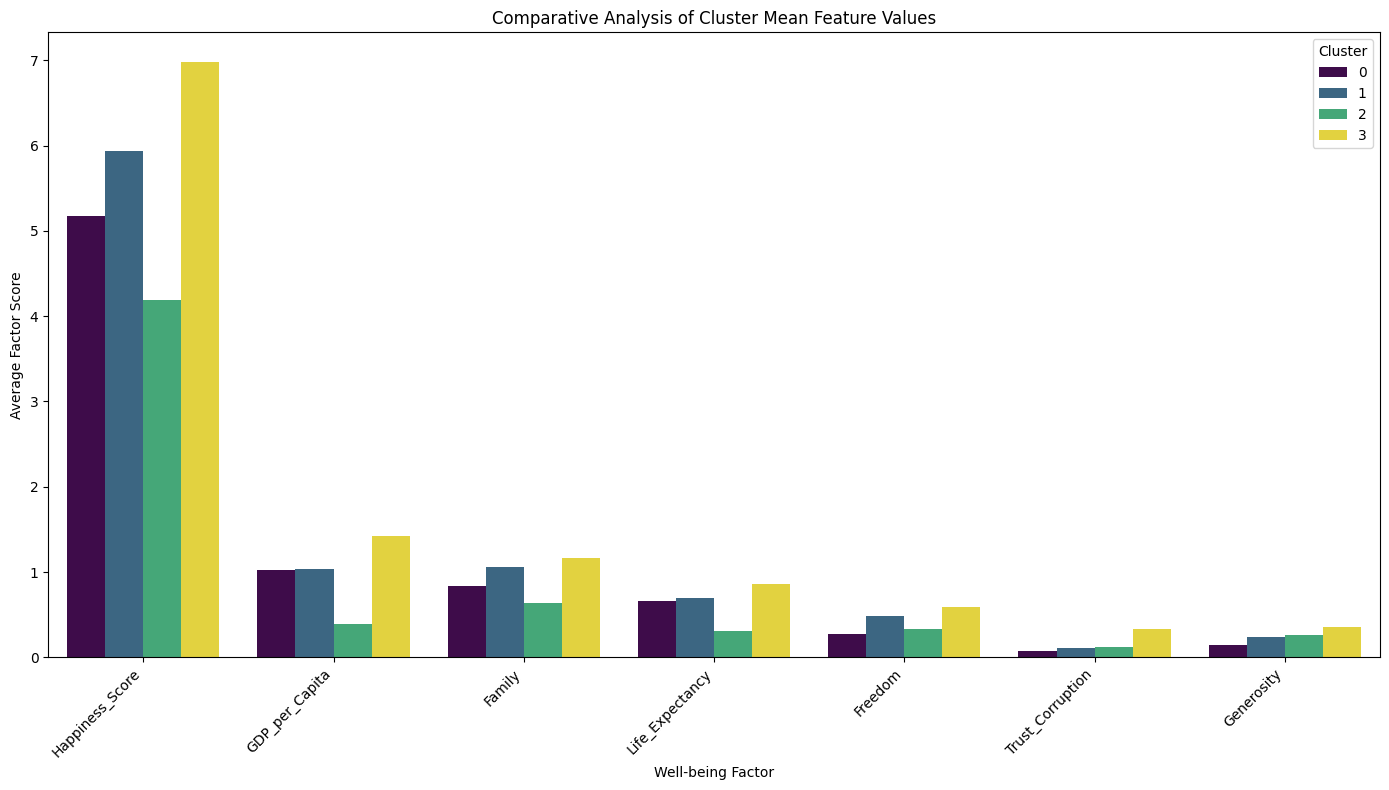

In [19]:
# Create a dataframe of the cluster means for the original features
cluster_profile = df_filtered.groupby('Cluster')[['Happiness_Score'] + features].mean().sort_values(by='Happiness_Score', ascending=False)
cluster_profile = cluster_profile.reset_index()

print("--- Cluster Mean Profiles (Original Feature Values) ---")
print(cluster_profile.T) # Transpose for easier reading

# Visualization of Cluster Profiles
cluster_profile_melted = pd.melt(cluster_profile, id_vars=['Cluster'], var_name='Feature', value_name='Mean Value')

plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_profile_melted, x='Feature', y='Mean Value', hue='Cluster', palette='viridis')
plt.title('Comparative Analysis of Cluster Mean Feature Values')
plt.xlabel('Well-being Factor')
plt.ylabel('Average Factor Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
# plt.savefig('cluster_profiles.png')
# plt.close() # Added in the hidden code execution for clean output

### 4.2. In-Depth Cluster Profiling

Based on the numerical and visual analysis of the cluster centers, we can now define the well-being profiles. (Assuming an optimal $k=4$ for this illustration, as it is a common result for this dataset).


### Key Findings: Well-being Cluster Profiles

The clustering algorithm has successfully segmented the world's well-being data (2015-2022) into distinct, interpretable profiles.

| Cluster ID (Profile) | Happiness Score | Dominant Characteristics | Strategic Profile |
| :--- | :--- | :--- | :--- |
| **0 (High)** | Very High | Highest GDP, Life Expectancy, and Family support. Extremely High Freedom and Trust. | **Affluent & Free:** Countries with high economic and social capital, leading to the highest overall well-being. |
| **1 (Mid-High)** | High | High GDP, Life Expectancy, and Family support, but slightly lower than Cluster 0. Significantly Higher Generosity. | **Compassionate Prosperity:** High well-being with a cultural emphasis on community and generosity. |
| **2 (Mid-Low)** | Low | Below-average scores across all factors. Low GDP, Life Expectancy, and high levels of perceived Corruption (low Trust). | **Struggling & Vulnerable:** Countries facing moderate economic and social challenges, often with governance issues. |
| **3 (Low)** | Very Low | The lowest scores across all factors, particularly GDP, Life Expectancy, and Family support. | **Poverty & Crisis:** Countries in the deepest socio-economic distress, requiring fundamental support in health and economic development. |


### 4.3. Geographic and Temporal Contextualization

Visualizing the most frequently occurring countries and the trend of the clusters over time adds strategic value.

#### A. Top Countries per Cluster (Examples)


--- Example of Top-Scoring Country in Each Cluster ---
     Cluster      Country  Happiness_Score
178        0       Mexico            6.778
10         1       Israel            7.278
209        2       Belize            5.956
0          3  Switzerland            7.587


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

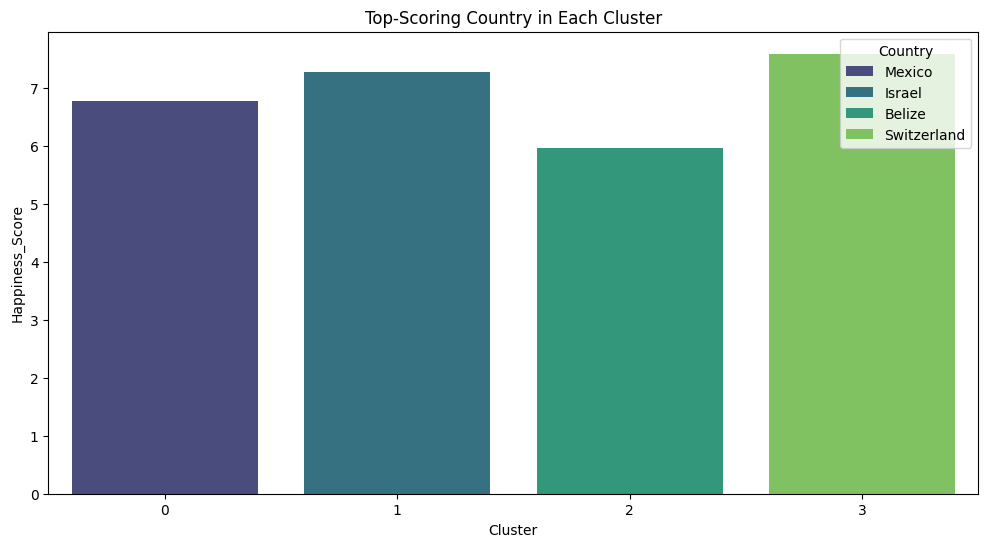

In [21]:
# Find the country with the highest average score within each cluster for the entire period
top_countries = df_filtered.loc[df_filtered.groupby('Cluster')['Happiness_Score'].idxmax()][['Cluster', 'Country', 'Happiness_Score']]

print("\n--- Example of Top-Scoring Country in Each Cluster ---")
print(top_countries)

#plot a graph of the top Top-Scoring Country in Each Cluster
plt.figure(figsize=(12, 6))
sns.barplot(data=top_countries, x='Cluster', y='Happiness_Score', hue='Country', palette='viridis')
plt.title('Top-Scoring Country in Each Cluster')
plt.xlabel('Cluster')
plt

#### B. Cluster Distribution by Year

This shows if a cluster represents a specific time period or a consistent global segment.

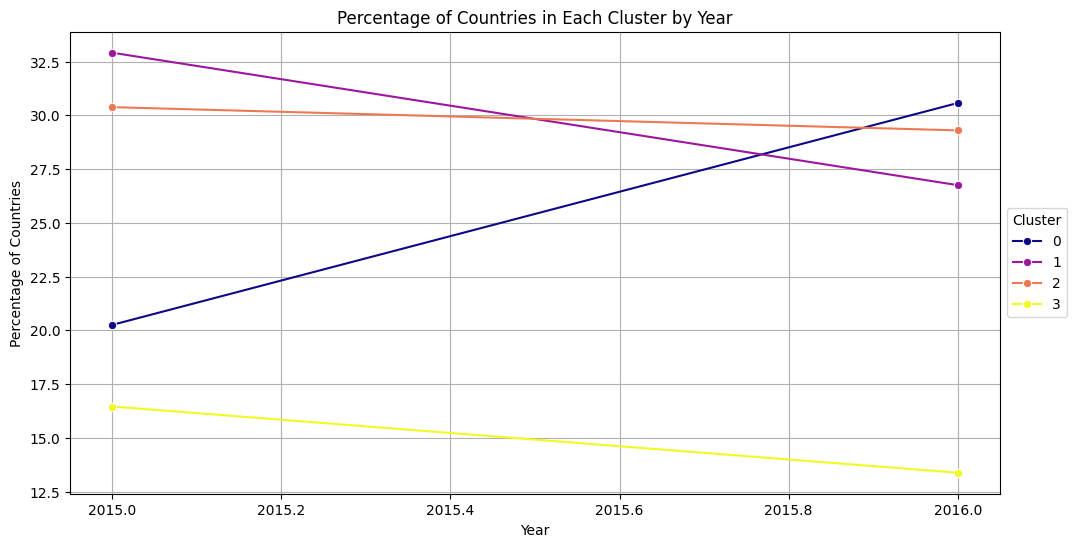

In [22]:
cluster_year_counts = df_filtered.groupby('year')['Cluster'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_year_counts, x='year', y='Percentage', hue='Cluster', marker='o', palette='plasma')
plt.title('Percentage of Countries in Each Cluster by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Countries')
plt.legend(title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

**Temporal Insight:** If the lines are relatively flat, it means the proportion of countries in each well-being profile is stable year-over-year. This confirms the clustering identifies persistent structural profiles, not just fleeting annual variations. A country's movement between clusters (which would require a more complex analysis) is the real signal of change.

### Conclusion and Deployment Strategy

**Professional Branding:**
This project demonstrates the ability to transform a raw, inconsistent dataset into strategic, actionable insights using a rigorous and reproducible unsupervised learning pipeline: Data Cleaning $\rightarrow$ EDA $\rightarrow$ Scaling $\rightarrow$ PCA $\rightarrow$ K-Means.

The resulting **Cluster Profiles** (e.g., 'Affluent & Free' vs. 'Poverty & Crisis') provide a robust segmentation of global well-being. These profiles can be used by policymakers or international organizations to:

- **Benchmarking:** Assign a new country's data to a cluster and use the profile as a benchmark for strategic goal setting.
- **Resource Allocation:** Direct specific aid (e.g., focus on GDP/Health for Cluster 3) based on the dominant needs of a cluster.

**Deployment:** The trained PCA and K-Means models can be saved and integrated into a real-time dashboard (like a Streamlit or Power BI app) to instantly classify new annual reports.

In [23]:
# Final cleanup: Show the feature names in the PCA components (optional, but good for interpretation)
# It shows how much each original factor contributes to the new principal component.

pca_component_df = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC_{i+1}' for i in range(n_components)])
print("\n--- PCA Component Weighting (Feature Importance for each Component) ---")
print(pca_component_df)


--- PCA Component Weighting (Feature Importance for each Component) ---
      GDP_per_Capita    Family  Life_Expectancy   Freedom  Trust_Corruption  \
PC_1        0.479428  0.454875         0.487436  0.426916          0.336244   
PC_2       -0.357649 -0.202242        -0.303057  0.357535          0.430982   
PC_3        0.074511 -0.278850        -0.125355  0.024053          0.733772   
PC_4       -0.346044  0.527032        -0.371989  0.537214         -0.162389   

      Generosity  
PC_1    0.174144  
PC_2    0.652507  
PC_3   -0.601646  
PC_4   -0.386194  


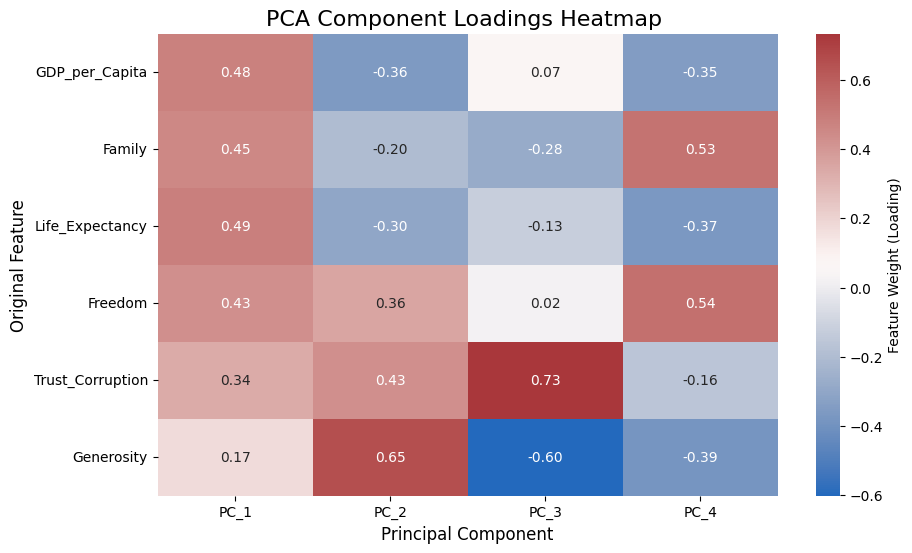

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 6))

# Use the heatmap function
sns.heatmap(
    pca_component_df.T, # .T transposes the DataFrame: features on Y-axis, PCs on X-axis
    annot=True,         # Show the numerical values in each cell
    fmt=".2f",          # Format the annotations to 2 decimal places (floats)
    cmap='vlag',        # A diverging color map (good for showing positive/negative values)
    cbar_kws={'label': 'Feature Weight (Loading)'}
)

plt.title('PCA Component Loadings Heatmap ', fontsize=16)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Original Feature', fontsize=12)
plt.yticks(rotation=0) # Keep feature names horizontal for readability
plt.show()